
Autor: Sebastian Rodriguez

Curso: Proicesamiento de Datos – Pontificia Universidad Javeriana

Fecha: 2025-09-03

Repositorio: https://github.com/T3cm0/Parcial-1-Procesamiento-de-Datos

Para el inicio de este notebook en Databricks primero debemos leer nuestros archivos de la ruta en donde los almacenamos, en mi caso quedaron en Volumes/workspace/default/parcial

In [0]:
import json
import os
from pyspark.sql import Row
from pyspark.sql import functions as F

# Ruta base del Volume donde subiste los archivos
catalog = "workspace"
schema  = "default"
volume  = "parcial"
BASE = f"/Volumes/{catalog}/{schema}/{volume}"
CSVS = f"{BASE}/csv_out"

arr = os.listdir(BASE)
arr2 = os.listdir(CSVS)
print(arr)
print(arr2)


['csv_out', 'figs', 'jugadores.csv', 'resultados_futbol.csv', 'temporadas.json']
['JugadoresJSON.csv', 'TeamsJSON.csv']


Convertimos el JSON que cuesta leer en un formato de tipo CSV.

In [0]:
import json, pandas as pd

IN  = f"/{BASE}/temporadas.json"
OUT = f"/{BASE}/csv_out"            

with open(IN, encoding="utf-8") as f:
    data = json.load(f)

In [0]:
# ---------- NIVEL EQUIPO/PARTIDO ----------
teams_list = []
HomeTeam = True
for X in data:
    for Y in data[str(X)]:
        team_details = (data[str(X)][str(Y)].get('team_details', {}) or {}).copy()
        aggregate_stats = data[str(X)][str(Y)].get('aggregate_stats', {}) or {}

        team_details.setdefault("team_id", Y)
        team_details['match_id'] = X
        team_details['team'] = "L" if HomeTeam else "V"
        HomeTeam = not HomeTeam

        # merge de agregados
        for k, v in aggregate_stats.items():
            team_details[k] = v

        teams_list.append(team_details)

df_teams = pd.DataFrame(teams_list)

cols_first = ['match_id', 'team_id', 'team_name', 'team']
cols_first = [c for c in cols_first if c in df_teams.columns]
df_teams = df_teams[cols_first + [c for c in df_teams.columns if c not in cols_first]]


In [0]:
# ---------- NIVEL JUGADOR ----------
players_list = []
for X in data:
    for Y in data[str(X)]:
        players = data[str(X)][str(Y)].get('Player_stats', {}) or {}
        for Z in players:
            d = {}
            pdet = (players[str(Z)].get('player_details', {}) or {})
            pms  = (players[str(Z)].get('Match_stats', {}) or {})

            d.update(pdet)
            d.update(pms)
            d['match'] = X
            d['team'] = Y
            d['player_name'] = pdet.get('player_name') or str(Z)

            players_list.append(d)

df_players = pd.DataFrame(players_list)

cols_first = ['match', 'team', 'player_name']
cols_first = [c for c in cols_first if c in df_players.columns]
df_players = df_players[cols_first + [c for c in df_players.columns if c not in cols_first]]


In [0]:
# ---------- GUARDAR ----------
import os
os.makedirs(OUT, exist_ok=True)
df_teams.to_csv(f"{OUT}/TeamsJSON.csv", index=False, encoding="utf-8")
df_players.to_csv(f"{OUT}/JugadoresJSON.csv", index=False, encoding="utf-8")
print("Listo:", f"{OUT}/TeamsJSON.csv", f"{OUT}/JugadoresJSON.csv")

Listo: //Volumes/workspace/default/parcial/csv_out/TeamsJSON.csv //Volumes/workspace/default/parcial/csv_out/JugadoresJSON.csv


Visualizamos los primeros 5 Datos de cada archivo incluuidos los de la conversion

In [0]:
jug = (spark.read.option("header","true").option("inferSchema","true").csv(f"{BASE}/jugadores.csv"))
res_futbol = (spark.read.option("header","true").option("inferSchema","true").csv(f"{BASE}/resultados_futbol.csv"))  
equ_json = (spark.read.option("header","true").option("inferSchema","true").csv(f"{BASE}/csv_out/TeamsJSON.csv"))
jug_json = (spark.read.option("header","true").option("inferSchema","true").csv(f"{BASE}/csv_out/JugadoresJSON.csv"))

display(jug.limit(5))
display(res_futbol.limit(5))
display(equ_json.limit(5))
display(jug_json.limit(5))

name,club,age,position,position_cat,market_value,page_views,fpl_value,fpl_sel,fpl_points,region,nationality,new_foreign,age_cat,club_id,big_club,new_signing
Alexis Sanchez,Arsenal,28,LW,1,65.0,4329,12.0,17.10%,264,3,Chile,0,4,1,1,0
Mesut Ozil,Arsenal,28,AM,1,50.0,4395,9.5,5.60%,167,2,Germany,0,4,1,1,0
Petr Cech,Arsenal,35,GK,4,7.0,1529,5.5,5.90%,134,2,Czech Republic,0,6,1,1,0
Theo Walcott,Arsenal,28,RW,1,20.0,2393,7.5,1.50%,122,1,England,0,4,1,1,0
Laurent Koscielny,Arsenal,31,CB,3,22.0,912,6.0,0.70%,121,2,France,0,4,1,1,0


Season,DateTime,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HC,AC,HF,AF,HY,AY,HR,AR
1993-94,1993-08-14T00:00:00.000Z,Arsenal,Coventry,0,3,A,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
1993-94,1993-08-14T00:00:00.000Z,Aston Villa,QPR,4,1,H,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
1993-94,1993-08-14T00:00:00.000Z,Chelsea,Blackburn,1,2,A,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
1993-94,1993-08-14T00:00:00.000Z,Liverpool,Sheffield Weds,2,0,H,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
1993-94,1993-08-14T00:00:00.000Z,Man City,Leeds,1,1,D,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


match_id,team_id,team_name,team,team_rating,date,won_corners,att_sv_low_centre,won_contest,total_tackle,aerial_lost,possession_percentage,accurate_pass,total_pass,total_throws,shot_off_target,total_offside,blocked_scoring_att,ontarget_scoring_att,aerial_won,att_miss_left,total_scoring_att,fk_foul_lost,att_miss_right,att_goal_low_left,att_goal_low_right,att_sv_low_left,goals,att_pen_goal,att_sv_high_centre,att_goal_low_centre,att_miss_high,att_post_left,post_scoring_att,att_miss_high_right,att_sv_high_right,att_sv_low_right,att_sv_high_left,att_miss_high_left,att_goal_high_right,att_goal_high_left,att_post_right,att_goal_high_centre,penalty_save,att_post_high
1190418,166,Huddersfield,L,6.14,2018-01-30,1,1,5,11,15,25.3,214,308,15,2,3,2,1,16,1,5,8,1,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
1190418,26,Liverpool,V,7.22285714285714,2018-01-30,4,2,6,13,16,74.7,809,913,24,3,2,4,7,15,null,14,8,3,1,1,1,3,1,1,1,null,null,null,null,null,null,null,null,null,null,null,null,null,null
1190424,211,Brighton,L,7.15384615384615,2018-01-01,5,1,12,23,16,49.1,300,394,21,3,1,6,6,25,null,15,13,2,null,1,3,2,null,null,1,1,null,null,null,null,null,null,null,null,null,null,null,null,null
1190424,183,Bournemouth,V,6.90285714285714,2018-01-01,12,3,17,6,25,50.9,329,403,19,5,null,13,8,16,null,26,9,2,1,1,null,2,null,null,null,1,1,1,1,1,2,null,null,null,null,null,null,null,null
1190342,15,Chelsea,L,6.77142857142857,2018-01-13,6,1,15,13,18,55.4,426,508,21,4,5,6,7,11,2,17,14,null,null,null,2,null,null,1,null,1,null,null,1,null,2,1,null,null,null,null,null,null,null


match,team,player_name,player_id,player_position_value,player_position_info,player_rating,good_high_claim,touches,saves,total_pass,formation_place,accurate_pass,aerial_won,aerial_lost,fouls,total_scoring_att,total_tackle,won_contest,penalty_conceded,blocked_scoring_att,man_of_the_match,goals,att_pen_goal,goal_assist,six_yard_block,yellow_card,error_lead_to_goal,post_scoring_att,second_yellow,red_card,clearance_off_line,own_goals,last_man_tackle,att_pen_target,penalty_save,att_pen_miss,att_pen_post
1190418,166,Jonas Lössl,131171,1,GK,6.61,2,39,4,28,1,11,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
1190418,166,Terence Kongolo,109117,2,DC,6.19,null,30,null,20,4,16,1,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
1190418,166,Chris Löwe,101664,2,DL,5.96,null,38,null,15,3,6,1,1,1,1,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
1190418,166,Zanka,29026,2,DC,6.65,null,44,null,28,6,27,1,null,1,null,3,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
1190418,166,Christopher Schindler,132360,2,DC,6.58,null,46,null,27,5,21,4,null,null,null,2,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null


Revisamos De cada archivo la cantidad de datos, el promedio, desviacion estandar, minimos y maximos.

In [0]:
for value in jug.columns:
    jug.describe([value]).show()


+-------+------------------+
|summary|              name|
+-------+------------------+
|  count|               461|
|   mean|              NULL|
| stddev|              NULL|
|    min|   Aaron Cresswell|
|    max|Åukasz FabiaÅ„ski|
+-------+------------------+

+-------+--------+
|summary|    club|
+-------+--------+
|  count|     461|
|   mean|    NULL|
| stddev|    NULL|
|    min| Arsenal|
|    max|West+Ham|
+-------+--------+

+-------+-----------------+
|summary|              age|
+-------+-----------------+
|  count|              461|
|   mean|26.80477223427332|
| stddev| 3.96189170370961|
|    min|               17|
|    max|               38|
+-------+-----------------+

+-------+--------+
|summary|position|
+-------+--------+
|  count|     461|
|   mean|    NULL|
| stddev|    NULL|
|    min|      AM|
|    max|      SS|
+-------+--------+

+-------+------------------+
|summary|      position_cat|
+-------+------------------+
|  count|               461|
|   mean| 2.1800433839479

In [0]:
for value in res_futbol.columns:
    res_futbol.describe([value]).show()

+-------+-------+
|summary| Season|
+-------+-------+
|  count|  11113|
|   mean|   NULL|
| stddev|   NULL|
|    min|1993-94|
|    max|2021-22|
+-------+-------+

+-------+
|summary|
+-------+
|  count|
|   mean|
| stddev|
|    min|
|    max|
+-------+

+-------+--------+
|summary|HomeTeam|
+-------+--------+
|  count|   11113|
|   mean|    NULL|
| stddev|    NULL|
|    min| Arsenal|
|    max|  Wolves|
+-------+--------+

+-------+--------+
|summary|AwayTeam|
+-------+--------+
|  count|   11113|
|   mean|    NULL|
| stddev|    NULL|
|    min| Arsenal|
|    max|  Wolves|
+-------+--------+

+-------+------------------+
|summary|              FTHG|
+-------+------------------+
|  count|             11113|
|   mean| 1.518221902276613|
| stddev|1.3019811033373492|
|    min|                 0|
|    max|                 9|
+-------+------------------+

+-------+-----------------+
|summary|             FTAG|
+-------+-----------------+
|  count|            11113|
|   mean|1.141455952488077|


In [0]:
for value in equ_json.columns:
    equ_json.describe([value]).show()

+-------+------------------+
|summary|          match_id|
+-------+------------------+
|  count|               760|
|   mean|         1190363.5|
| stddev|109.76841114055298|
|    min|           1190174|
|    max|           1190553|
+-------+------------------+

+-------+-----------------+
|summary|          team_id|
+-------+-----------------+
|  count|              760|
|   mean|            93.05|
| stddev|81.87226224691857|
|    min|               13|
|    max|              259|
+-------+-----------------+

+-------+---------+
|summary|team_name|
+-------+---------+
|  count|      760|
|   mean|     NULL|
| stddev|     NULL|
|    min|  Arsenal|
|    max| West Ham|
+-------+---------+

+-------+----+
|summary|team|
+-------+----+
|  count| 760|
|   mean|NULL|
| stddev|NULL|
|    min|   L|
|    max|   V|
+-------+----+

+-------+-------------------+
|summary|        team_rating|
+-------+-------------------+
|  count|                760|
|   mean|  6.779921467786607|
| stddev|0.3776833

In [0]:
for value in jug_json.columns:
    jug_json.describe([value]).show()

+-------+------------------+
|summary|             match|
+-------+------------------+
|  count|             13675|
|   mean| 1190363.506252285|
| stddev|109.71307940913249|
|    min|           1190174|
|    max|           1190553|
+-------+------------------+

+-------+-----------------+
|summary|             team|
+-------+-----------------+
|  count|            13675|
|   mean|93.04387568555758|
| stddev|81.82597092854478|
|    min|               13|
|    max|              259|
+-------+-----------------+

+-------+---------------+
|summary|    player_name|
+-------+---------------+
|  count|          13675|
|   mean|           NULL|
| stddev|           NULL|
|    min|Aaron Cresswell|
|    max|  Álvaro Morata|
+-------+---------------+

+-------+-----------------+
|summary|        player_id|
+-------+-----------------+
|  count|            13675|
|   mean|87801.52987202925|
| stddev|81854.63725526667|
|    min|              188|
|    max|           357427|
+-------+-----------------

### Glosario jugadores.csv
- `name (string)`: nombre del jugador.
- `club (string)`: club actual.
- `age (int)`: edad del jugador (años).
- `position (string)`: posición principal (p. ej., GK/DF/MF/FW).
- `position_cat (int)`: categoría numérica de posición (definida por el dataset; p. ej., 1=GK, 2=DF, 3=MF, 4=FW).
- `market_value (double)`: valor de mercado estimado (no es la tarifa de traspaso).
- `page_views (int)`: vistas de página/popularidad (según la fuente del dataset).
- `fpl_value (double)`: “valor” en Fantasy Premier League (p. ej., puntos/precio).
- `fpl_sel (string)`: “Selected by %” — porcentaje de mánagers FPL que poseen al jugador (ej.: "23.4" o "23.4%").
- `fpl_points (int)`: puntos FPL acumulados (según el sistema oficial).
- `region (string)`: región del jugador en el dataset (ej.: "Europe").
- `nationality (string)`: país/nacionalidad del jugador.
- `new_foreign (int)`: indicador (0/1) de extranjero recién incorporado al club en la temporada (según reglas del dataset).
- `age_cat (int)`: categoría/bins de edad (definida por el dataset; confirmar mapeo real).
- `club_id (int)`: identificador del club en el proveedor/dataset.
- `big_club (int)`: indicador (0/1) de “club grande” (criterio del dataset; ej., Big-6).
- `new_signing (int)`: indicador (0/1) de fichaje reciente (aclarar si incluye cesiones).


### Glosario resultados_futbol.csv
- `Season (string)`: temporada (p. ej., "2018/2019").
- `DateTime (timestamp)`: fecha y hora del kickoff.
- `HomeTeam (string)`: equipo local.
- `AwayTeam (string)`: equipo visitante.
- `FTHG (int)`: goles del local al final del partido.
- `FTAG (int)`: goles del visitante al final del partido.
- `FTR (string)`: resultado final — H (gana local), D (empate), A (gana visitante).
- `HTHG (string/int)`: goles del local al descanso.
- `HTAG (string/int)`: goles del visitante al descanso.
- `HTR (string)`: resultado al descanso — H/D/A.
- `Referee (string)`: árbitro principal.
- `HS (string/int)`: tiros del equipo local.
- `AS (string/int)`: tiros del equipo visitante.
- `HST (string/int)`: tiros a puerta del local.
- `AST (string/int)`: tiros a puerta del visitante.
- `HC (string/int)`: córners del local.
- `AC (string/int)`: córners del visitante.
- `HF (string/int)`: faltas cometidas por el local.
- `AF (string/int)`: faltas cometidas por el visitante.
- `HY (string/int)`: amarillas del local.
- `AY (string/int)`: amarillas del visitante.
- `HR (string/int)`: rojas del local.

### Glosario TeamsJSON.csv
- `match_id (int)`: identificador único del partido.
- `team_id (int)`: identificador del equipo (proveedor).
- `team_name (string)`: nombre del equipo.
- `team (string)`: condición en el partido — "L" local, "V" visitante.
- `team_rating (double)`: calificación algorítmica del rendimiento del equipo.
- `date (date)`: fecha del partido.
- `won_corners (int)`: córners ganados por el equipo.
- `att_sv_low_centre (int)`: tiros a puerta del rival parados por el portero, dirigidos a la zona baja–central.
- `won_contest (int)`: duelos ganados (aéreos/terrestres según proveedor).
- `total_tackle (int)`: entradas (tackles) realizadas.
- `aerial_lost (int)`: duelos aéreos perdidos.
- `possession_percentage (double)`: porcentaje de posesión (0–100).
- `accurate_pass (int)`: pases completados por el equipo.

### Glosario JugadoresJSON.csv
- `match (int)`: identificador del partido. 
- `team (int)`: identificador/código del equipo en ese partido.  
- `player_name (string)`: nombre del jugador en el registro del partido.  
- `player_id (int)`: identificador del jugador.  
- `player_position_value (int)`: codificación numérica de la posición/rol en el partido.  
- `player_position_info (string)`: texto descriptivo de la posición/rol en el partido.  
- `player_rating (double)`: calificación algorítmica del rendimiento individual.  
- `good_high_claim (int)`: **portero** – balones aéreos altos atrapados con éxito (no “punch”).  
- `touches (int)`: toques de balón.  
- `saves (int)`: **portero** – paradas (tiros a puerta detenidos).  
- `total_pass (int)`: pases intentados.  
- `formation_place (int)`: índice/posición dentro del once según el dibujo táctico.  
- `accurate_pass (int)`: pases completados (acertados).  
- `aerial_won (int)`: duelos aéreos ganados.  
- `aerial_lost (int)`: duelos aéreos perdidos.  
- `fouls (int)`: faltas cometidas.  
- `total_scoring_att (int)`: tiros totales (attempts).  
- `total_tackle (int)`: entradas realizadas.  
- `won_contest (int)`: duelos ganados (incluye aéreos/terrestres según proveedor).  
- `penalty_conceded (int)`: penaltis concedidos por el jugador.  
- `blocked_scoring_att (int)`: tiros del rival bloqueados.  
- `man_of_the_match (int)`: indicador del premio “Jugador del partido”.

Cargamos en SQL los CSV para poder realizar consultas

In [0]:
%sql
CREATE OR REPLACE TEMP VIEW teams AS
SELECT *
FROM read_files(
  '/Volumes/workspace/default/parcial/csv_out/TeamsJSON.csv',
  format => 'csv', header => true, inferSchema => true, nullValue => ''
);

CREATE OR REPLACE TEMP VIEW players_match AS
SELECT *
FROM read_files(
  '/Volumes/workspace/default/parcial/csv_out/JugadoresJSON.csv',
  format => 'csv', header => true, inferSchema => true, nullValue => ''
);

CREATE OR REPLACE TEMP VIEW players AS
SELECT *
FROM read_files(
  '/Volumes/workspace/default/parcial/jugadores.csv',
  format => 'csv', header => true, inferSchema => true, nullValue => ''
);

CREATE OR REPLACE TEMP VIEW results AS
SELECT *
FROM read_files(
  '/Volumes/workspace/default/parcial/resultados_futbol.csv',
  format => 'csv', header => true, inferSchema => true, nullValue => ''
);

Miramos en todos los archivos el conteo de contenido quue sea igual a NULL

In [0]:
%sql
SELECT stack(13,
  'match_id', SUM(CASE WHEN match_id IS NULL THEN 1 ELSE 0 END),
  'team_id', SUM(CASE WHEN team_id IS NULL THEN 1 ELSE 0 END),
  'team_name', SUM(CASE WHEN team_name IS NULL THEN 1 ELSE 0 END),
  'team', SUM(CASE WHEN team IS NULL THEN 1 ELSE 0 END),
  'team_rating', SUM(CASE WHEN team_rating IS NULL THEN 1 ELSE 0 END),
  'date', SUM(CASE WHEN date IS NULL THEN 1 ELSE 0 END),
  'won_corners', SUM(CASE WHEN won_corners IS NULL THEN 1 ELSE 0 END),
  'att_sv_low_centre', SUM(CASE WHEN att_sv_low_centre IS NULL THEN 1 ELSE 0 END),
  'won_contest', SUM(CASE WHEN won_contest IS NULL THEN 1 ELSE 0 END),
  'total_tackle', SUM(CASE WHEN total_tackle IS NULL THEN 1 ELSE 0 END),
  'aerial_lost', SUM(CASE WHEN aerial_lost IS NULL THEN 1 ELSE 0 END),
  'possession_percentage', SUM(CASE WHEN possession_percentage IS NULL THEN 1 ELSE 0 END),
  'accurate_pass', SUM(CASE WHEN accurate_pass IS NULL THEN 1 ELSE 0 END)
) AS (column_name, null_count)
FROM teams;

column_name,null_count
match_id,0
team_id,0
team_name,0
team,0
team_rating,0
date,0
won_corners,16
att_sv_low_centre,269
won_contest,0
total_tackle,0


In [0]:
%sql
-- Nulls por columna en players_match (exactamente tus 22 columnas)
  SELECT stack(22,
    'match',                 SUM(CASE WHEN `match`               IS NULL THEN 1 ELSE 0 END),
    'team',                  SUM(CASE WHEN team                  IS NULL THEN 1 ELSE 0 END),
    'player_name',           SUM(CASE WHEN player_name           IS NULL THEN 1 ELSE 0 END),
    'player_id',             SUM(CASE WHEN player_id             IS NULL THEN 1 ELSE 0 END),
    'player_position_value', SUM(CASE WHEN player_position_value IS NULL THEN 1 ELSE 0 END),
    'player_position_info',  SUM(CASE WHEN player_position_info  IS NULL THEN 1 ELSE 0 END),
    'player_rating',         SUM(CASE WHEN player_rating         IS NULL THEN 1 ELSE 0 END),
    'good_high_claim',       SUM(CASE WHEN good_high_claim       IS NULL THEN 1 ELSE 0 END),
    'touches',               SUM(CASE WHEN touches               IS NULL THEN 1 ELSE 0 END),
    'saves',                 SUM(CASE WHEN saves                 IS NULL THEN 1 ELSE 0 END),
    'total_pass',            SUM(CASE WHEN total_pass            IS NULL THEN 1 ELSE 0 END),
    'formation_place',       SUM(CASE WHEN formation_place       IS NULL THEN 1 ELSE 0 END),
    'accurate_pass',         SUM(CASE WHEN accurate_pass         IS NULL THEN 1 ELSE 0 END),
    'aerial_won',            SUM(CASE WHEN aerial_won            IS NULL THEN 1 ELSE 0 END),
    'aerial_lost',           SUM(CASE WHEN aerial_lost           IS NULL THEN 1 ELSE 0 END),
    'fouls',                 SUM(CASE WHEN fouls                 IS NULL THEN 1 ELSE 0 END),
    'total_scoring_att',     SUM(CASE WHEN total_scoring_att     IS NULL THEN 1 ELSE 0 END),
    'total_tackle',          SUM(CASE WHEN total_tackle          IS NULL THEN 1 ELSE 0 END),
    'won_contest',           SUM(CASE WHEN won_contest           IS NULL THEN 1 ELSE 0 END),
    'penalty_conceded',      SUM(CASE WHEN penalty_conceded      IS NULL THEN 1 ELSE 0 END),
    'blocked_scoring_att',   SUM(CASE WHEN blocked_scoring_att   IS NULL THEN 1 ELSE 0 END),
    'man_of_the_match',      SUM(CASE WHEN man_of_the_match      IS NULL THEN 1 ELSE 0 END)
  ) AS (column_name, null_count)
  FROM players_match;



column_name,null_count
match,0
team,0
player_name,0
player_id,0
player_position_value,0
player_position_info,0
player_rating,0
good_high_claim,13330
touches,3276
saves,12974


In [0]:
%sql
SELECT stack(12,
  'name', SUM(CASE WHEN name IS NULL THEN 1 ELSE 0 END),
  'club', SUM(CASE WHEN club IS NULL THEN 1 ELSE 0 END),
  'age', SUM(CASE WHEN age IS NULL THEN 1 ELSE 0 END),
  'position', SUM(CASE WHEN position IS NULL THEN 1 ELSE 0 END),
  'position_cat', SUM(CASE WHEN position_cat IS NULL THEN 1 ELSE 0 END),
  'market_value', SUM(CASE WHEN market_value IS NULL THEN 1 ELSE 0 END),
  'page_views', SUM(CASE WHEN page_views IS NULL THEN 1 ELSE 0 END),
  'fpl_value', SUM(CASE WHEN fpl_value IS NULL THEN 1 ELSE 0 END),
  'fpl_points', SUM(CASE WHEN fpl_points IS NULL THEN 1 ELSE 0 END),
  'region', SUM(CASE WHEN region IS NULL THEN 1 ELSE 0 END),
  'nationality', SUM(CASE WHEN nationality IS NULL THEN 1 ELSE 0 END),
  'club_id', SUM(CASE WHEN club_id IS NULL THEN 1 ELSE 0 END)
) AS (column_name, null_count)
FROM players;

column_name,null_count
name,0
club,0
age,0
position,0
position_cat,0
market_value,0
page_views,0
fpl_value,0
fpl_points,0
region,0


In [0]:
%sql
SELECT stack(10,
  'Season', SUM(CASE WHEN Season IS NULL THEN 1 ELSE 0 END),
  'DateTime', SUM(CASE WHEN DateTime IS NULL THEN 1 ELSE 0 END),
  'HomeTeam', SUM(CASE WHEN HomeTeam IS NULL THEN 1 ELSE 0 END),
  'AwayTeam', SUM(CASE WHEN AwayTeam IS NULL THEN 1 ELSE 0 END),
  'FTHG', SUM(CASE WHEN FTHG IS NULL THEN 1 ELSE 0 END),
  'FTAG', SUM(CASE WHEN FTAG IS NULL THEN 1 ELSE 0 END),
  'FTR', SUM(CASE WHEN FTR IS NULL THEN 1 ELSE 0 END),
  'HST', SUM(CASE WHEN HST IS NULL THEN 1 ELSE 0 END),
  'AST', SUM(CASE WHEN AST IS NULL THEN 1 ELSE 0 END),
  'Referee', SUM(CASE WHEN Referee IS NULL THEN 1 ELSE 0 END)
) AS (column_name, null_count)
FROM results;


column_name,null_count
Season,0
DateTime,0
HomeTeam,0
AwayTeam,0
FTHG,0
FTAG,0
FTR,0
HST,0
AST,0
Referee,0


Miramos si existen duplicados

In [0]:
%sql
-- Teams: duplicados por (match_id, team_id)
SELECT match_id, team_id, COUNT(*) AS cnt
FROM teams
GROUP BY match_id, team_id
HAVING COUNT(*) > 1;

-- Players_match: duplicados por (match, team, player_id)
SELECT match, team, player_id, COUNT(*) AS cnt
FROM players_match
GROUP BY match, team, player_id
HAVING COUNT(*) > 1;


match,team,player_id,cnt


Controles de rango para porcentajes, validar cuales no estan presentes en esos intervalos.

In [0]:
%sql
-- Posesión fuera de 0–100
SELECT COUNT(*) AS bad_possession
FROM teams
WHERE possession_percentage < 0 OR possession_percentage > 100;

-- Goles negativos (no debería ocurrir)
SELECT COUNT(*) AS bad_goals
FROM results
WHERE FTHG < 0 OR FTAG < 0;


bad_goals
0


Descriptivos de las variables clave (SQL)

In [0]:
%sql
-- Teams: descriptivos de posesión y pases
SELECT
  COUNT(*) AS n,
  AVG(possession_percentage) AS mean_possession,
  STDDEV(possession_percentage) AS sd_possession,
  PERCENTILE_APPROX(possession_percentage, 0.5) AS median_possession,
  MIN(possession_percentage) AS min_possession,
  MAX(possession_percentage) AS max_possession,
  AVG(accurate_pass) AS mean_acc_pass
FROM teams;

-- Players_match: rating y tiros
SELECT
  COUNT(*) AS n,
  AVG(player_rating) AS mean_rating,
  STDDEV(player_rating) AS sd_rating,
  PERCENTILE_APPROX(player_rating, 0.25) AS p25_rating,
  PERCENTILE_APPROX(player_rating, 0.5) AS p50_rating,
  PERCENTILE_APPROX(player_rating, 0.75) AS p75_rating,
  AVG(total_scoring_att) AS mean_shots
FROM players_match;

-- Results: goles locales/visitantes
SELECT
  COUNT(*) AS n,
  AVG(FTHG) AS mean_home_goals,
  AVG(FTAG) AS mean_away_goals,
  CORR(FTHG, FTAG) AS corr_home_away_goals
FROM results;


n,mean_home_goals,mean_away_goals,corr_home_away_goals
11113,1.518221902276613,1.141455952488077,-0.05547357731077987


Distribución de player_rating (histograma)

In [0]:
%sql
SELECT
  CAST(FLOOR(player_rating * 2)/2.0 AS DOUBLE) AS rating_bin,  -- bins de 0.5
  COUNT(*) AS n
FROM players_match
WHERE player_rating IS NOT NULL
GROUP BY CAST(FLOOR(player_rating * 2)/2.0 AS DOUBLE)
ORDER BY rating_bin;


rating_bin,n
0.0,3227
3.5,1
4.0,3
4.5,30
5.0,87
5.5,987
6.0,3096
6.5,2586
7.0,2018
7.5,1009


Posesión vs tiros a puerta del equipo 

In [0]:
%sql
SELECT
  ROUND(possession_percentage, 0) AS possession_pct_rounded,
  AVG(accurate_pass) AS avg_acc_pass
FROM teams
WHERE possession_percentage IS NOT NULL
GROUP BY ROUND(possession_percentage, 0)
ORDER BY possession_pct_rounded;

possession_pct_rounded,avg_acc_pass
17.0,142.0
18.0,133.0
19.0,88.0
20.0,114.0
21.0,123.2
22.0,136.0
23.0,158.4
24.0,119.0
25.0,177.0
26.0,174.125


Goles por resultado (FTR)

In [0]:
%sql
SELECT
  FTR,
  AVG(FTHG) AS avg_home_goals,
  AVG(FTAG) AS avg_away_goals
FROM results
GROUP BY FTR
ORDER BY FTR;


FTR,avg_home_goals,avg_away_goals
A,0.5691236950332174,2.274280291047137
D,0.9696229050279329,0.9696229050279329
H,2.4166666666666665,0.5343946540880503


Definimos unas funciones para construir unas graficas visuales

In [0]:
import os, pandas as pd
import matplotlib.pyplot as plt

catalog = "workspace"; schema = "default"; volume = "parcial"
BASE = f"/Volumes/{catalog}/{schema}/{volume}"
OUT_FIGS = f"/{BASE}/figs"; os.makedirs(OUT_FIGS, exist_ok=True)


In [0]:
def styled_fig(title=None, xlabel=None, ylabel=None):
    fig, ax = plt.subplots(num=None, figsize=(13, 7), facecolor='w', edgecolor='k')
    if title: fig.suptitle(title)
    if xlabel: ax.set_xlabel(xlabel)
    if ylabel: ax.set_ylabel(ylabel)
    ax.grid(True)
    return fig, ax


In [0]:
def _series_from_df(obj, col, sample_limit=300_000):
    """Devuelve una pd.Series numérica desde Spark o pandas DF."""
    import pandas as pd
    # Spark DF: tiene .select
    if hasattr(obj, "select"):
        from pyspark.sql import functions as F
        sdf = obj.select(F.col(col)).where(F.col(col).isNotNull())
        pdf = sdf.limit(sample_limit).toPandas()
        return pd.to_numeric(pdf[col], errors="coerce").dropna()
    # pandas DF: tiene .columns pero no .select
    elif hasattr(obj, "columns"):
        return pd.to_numeric(obj[col], errors="coerce").dropna()
    else:
        raise TypeError("Objeto no reconocido: se espera Spark o pandas DataFrame.")

In [0]:
def hist_df(obj, col, bins=20, title=None, xlabel=None, ylabel="Frecuencia", filename=None):
    s = _series_from_df(obj, col)
    fig, ax = styled_fig(title or f"Histograma: {col}", xlabel or col, ylabel)
    ax.hist(s, bins=bins, label=col)
    ax.legend(); plt.tight_layout()
    if filename:
        path = os.path.join(OUT_FIGS, filename); plt.savefig(path, dpi=150); print(f"Guardado: {path}")
    plt.show()

In [0]:
def scatter_df(obj, x_col, y_col, title=None, xlabel=None, ylabel=None, filename=None, alpha=0.25):
    # Construye DataFrame pandas con ambas columnas
    if hasattr(obj, "select"):
        from pyspark.sql import functions as F
        pdf = (obj.select(x_col, y_col)
                 .where(F.col(x_col).isNotNull() & F.col(y_col).isNotNull())
                 .limit(300_000).toPandas().dropna())
    else:
        pdf = obj[[x_col, y_col]].dropna()
    fig, ax = styled_fig(title or f"{y_col} vs {x_col}", xlabel or x_col, ylabel or y_col)
    ax.scatter(pdf[x_col].values, pdf[y_col].values, alpha=alpha, label=f"{y_col} vs {x_col}")
    ax.legend(); plt.tight_layout()
    if filename:
        path = os.path.join(OUT_FIGS, filename); plt.savefig(path, dpi=150); print(f"Guardado: {path}")
    plt.show()

In [0]:
from pyspark.sql import DataFrame
from pyspark.sql import functions as F

catalog = "workspace"; schema = "default"; volume = "parcial"
BASE = f"/Volumes/{catalog}/{schema}/{volume}"

def ensure_df(name: str, view_name: str, csv_path: str) -> DataFrame:
    # 1) ¿ya existe en variables?
    obj = globals().get(name, None)
    if isinstance(obj, DataFrame):
        print(f"{name}: ya existía en memoria")
        return obj

    # 2) ¿existe una VIEW/TABLE con ese nombre?
    try:
        df = spark.table(view_name)
        print(f"{name}: cargado desde VIEW/TABLE '{view_name}'")
    except Exception:
        # 3) lee el CSV desde Volumes
        path = f"{BASE}/{csv_path}"
        df = (spark.read.option("header","true").option("inferSchema","true").csv(path))
        print(f"{name}: cargado desde {path}")

    globals()[name] = df
    return df


In [0]:
# Lista lo que hay en el Volume
print("BASE =", BASE)
print("Contenido de BASE:")
display(dbutils.fs.ls(BASE))

BASE = /Volumes/workspace/default/parcial
Contenido de BASE:


path,name,size,modificationTime
dbfs:/Volumes/workspace/default/parcial/csv_out/,csv_out/,0,1757307712059
dbfs:/Volumes/workspace/default/parcial/figs/,figs/,0,1757307712059
dbfs:/Volumes/workspace/default/parcial/jugadores.csv,jugadores.csv,34635,1757233043000
dbfs:/Volumes/workspace/default/parcial/resultados_futbol.csv,resultados_futbol.csv,1082023,1757233043000
dbfs:/Volumes/workspace/default/parcial/temporadas.json,temporadas.json,10371723,1757233045000


In [0]:
try:
    print("Contenido de csv_out:")
    display(dbutils.fs.ls(f"{BASE}/csv_out"))
except Exception as e:
    print("No hay csv_out o no es accesible:", e)

Contenido de csv_out:


path,name,size,modificationTime
dbfs:/Volumes/workspace/default/parcial/csv_out/JugadoresJSON.csv,JugadoresJSON.csv,1105537,1757307576000
dbfs:/Volumes/workspace/default/parcial/csv_out/TeamsJSON.csv,TeamsJSON.csv,95138,1757307575000


In [0]:
# Heurística: busca un archivo/directorio que parezca players_match
def pick_first_match(dirpath, candidates):
    try:
        items = dbutils.fs.ls(dirpath)
    except Exception:
        return None
    names = [it.name.rstrip("/") for it in items]
    for cand in candidates:
        for nm in names:
            if nm.lower() == cand.lower():
                return f"{dirpath}/{nm}"
    # coincidencia relajada (empieza con…)
    for cand in candidates:
        for nm in names:
            if nm.lower().startswith(cand.lower()):
                return f"{dirpath}/{nm}"
    return None

In [0]:
# candidatos comunes (ajusta si ves otros en el listado)
cands = ["JugadoresJSON.csv", "JugadoresJSON", "players_match.csv", "players_match"]
pm_path = (pick_first_match(f"{BASE}/csv_out", cands)
           or pick_first_match(BASE, cands))

if pm_path is None:
    raise FileNotFoundError("No encontré el CSV de jugadores-partido. Mira los listados arriba y dime el nombre exacto.")

print("Usando ruta:", pm_path)

Usando ruta: /Volumes/workspace/default/parcial/csv_out/JugadoresJSON.csv


In [0]:
# Carga definitiva
df_players_match = (spark.read.option("header","true").option("inferSchema","true").csv(pm_path))
print("cols players_match:", df_players_match.columns[:12], "...")

cols players_match: ['match', 'team', 'player_name', 'player_id', 'player_position_value', 'player_position_info', 'player_rating', 'good_high_claim', 'touches', 'saves', 'total_pass', 'formation_place'] ...


Guardado: //Volumes/workspace/default/parcial/figs/hist_teams_possession.png


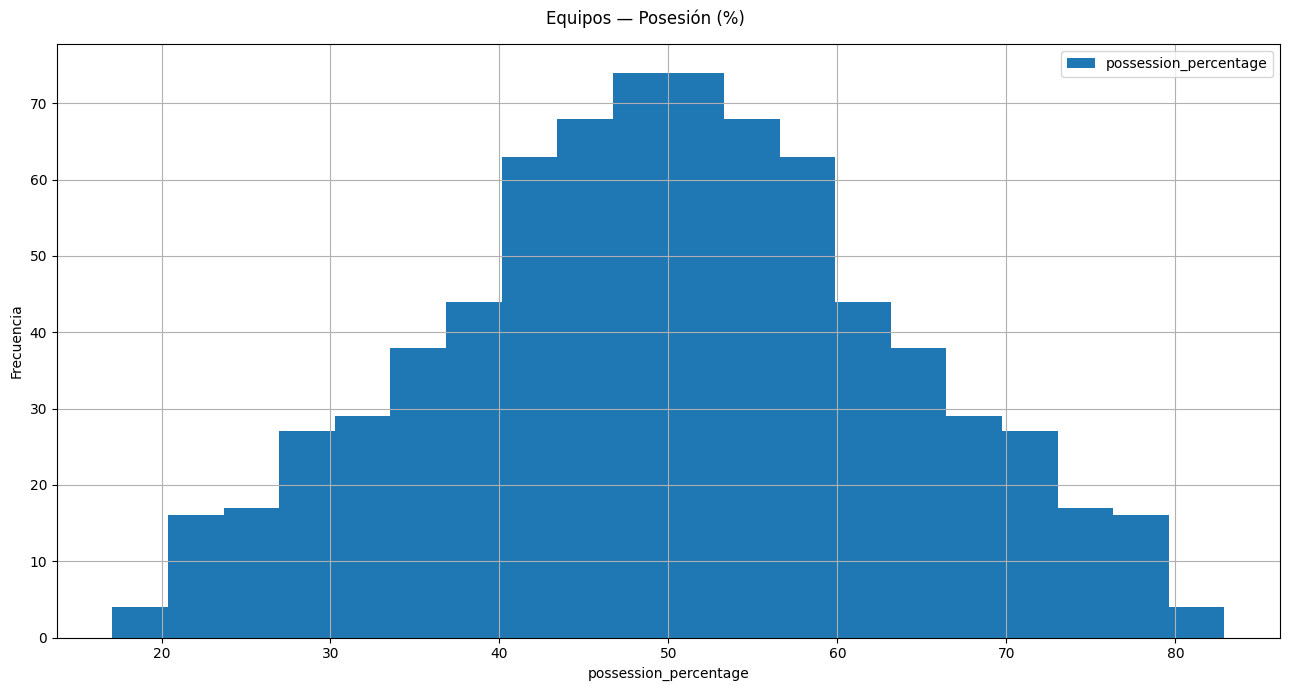

Guardado: //Volumes/workspace/default/parcial/figs/hist_players_rating.png


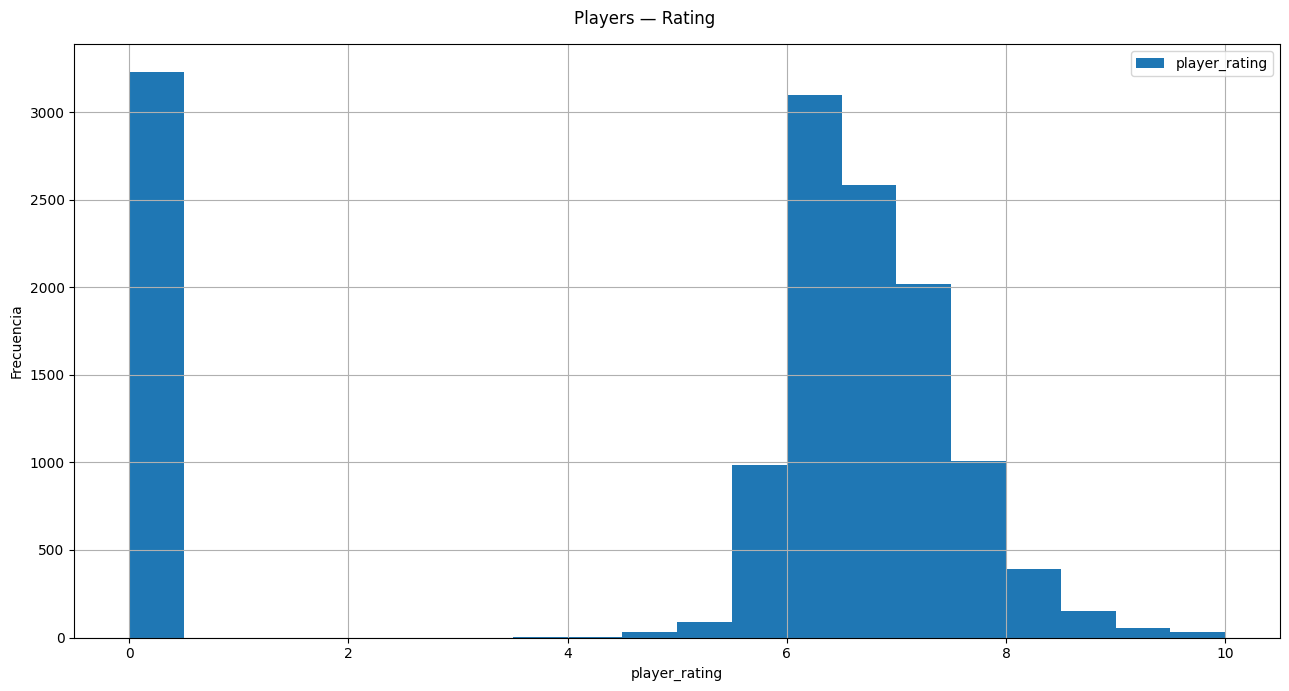

Guardado: //Volumes/workspace/default/parcial/figs/scatter_players_shots_vs_rating.png


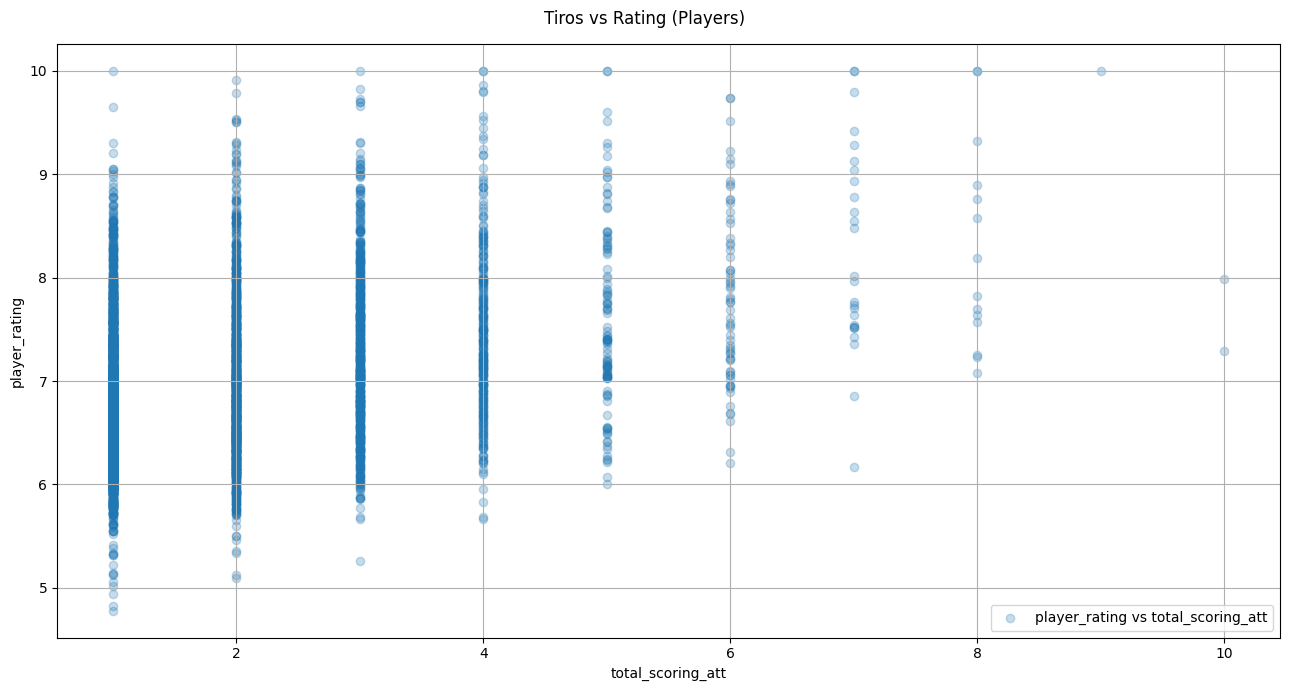

In [0]:
# Histogramas/Scatter (usa los helpers hist_df / scatter_df que ya definiste)
hist_df(df_teams, "possession_percentage", bins=20,
        title="Equipos — Posesión (%)",
        filename="hist_teams_possession.png")

hist_df(df_players_match, "player_rating", bins=20,
        title="Jugadores — Rating",
        filename="hist_players_rating.png")

scatter_df(df_players_match, "total_scoring_att", "player_rating",
           title="Tiros vs Rating (Jugadores)",
           filename="scatter_players_shots_vs_rating.png")


Construimos graficas para visualizar dos series

In [0]:
# ---- Doble serie: posesión (bin) vs métricas ----
import pandas as pd
import matplotlib.pyplot as plt

In [0]:
# ---- Normaliza df_teams a pandas (solo columnas necesarias) ----
if hasattr(df_teams, "select"):  # Spark DF
    t = (df_teams
         .select("possession_percentage","accurate_pass","team_rating","match_id","team_id")
         .toPandas())
else:                             # pandas DF
    t = df_teams

In [0]:
# Tipos numéricos seguros
for c in ["possession_percentage","accurate_pass","team_rating","match_id","team_id"]:
    if c in t.columns:
        t[c] = pd.to_numeric(t[c], errors="coerce")

t["pos_bin"] = t["possession_percentage"].round()

In [0]:
# Serie 1: pases acertados promedio (y rating si existe) por bin
s1 = (t.groupby("pos_bin", dropna=True)
        .agg(avg_acc_pass=("accurate_pass","mean"),
             avg_team_rating=("team_rating","mean"))
        .reset_index()
        .sort_values("pos_bin"))

pdf = s1.copy()


In [0]:
# ---- Serie 2 (opcional): tiros promedio por bin (desde players_match) ----
if 'df_players_match' in globals():
    if hasattr(df_players_match, "select"):  # Spark DF → agrega y baja a pandas
        pm_pdf = (df_players_match
                    .selectExpr("cast(match as int) as match_id",
                                "cast(team as int) as team_id",
                                "cast(total_scoring_att as double) as team_shots")
                    .groupBy("match_id","team_id")
                    .sum("team_shots")
                    .withColumnRenamed("sum(team_shots)","team_shots")
                    .toPandas())
    else:                                     # pandas DF
        pm_pdf = df_players_match[["match","team","total_scoring_att"]].rename(
            columns={"match":"match_id","team":"team_id"})
        pm_pdf["match_id"]   = pd.to_numeric(pm_pdf["match_id"], errors="coerce")
        pm_pdf["team_id"]    = pd.to_numeric(pm_pdf["team_id"], errors="coerce")
        pm_pdf["team_shots"] = pd.to_numeric(pm_pdf["total_scoring_att"], errors="coerce")
        pm_pdf = (pm_pdf.groupby(["match_id","team_id"], dropna=True)["team_shots"]
                        .sum().reset_index())

    # Une bin de posesión con tiros y promedia por bin
    s2pdf = (t[["match_id","team_id","pos_bin"]]
             .merge(pm_pdf, on=["match_id","team_id"], how="inner")
             .groupby("pos_bin", dropna=True)["team_shots"]
             .mean().reset_index(name="avg_team_shots"))

    pdf = pdf.merge(s2pdf, on="pos_bin", how="left")

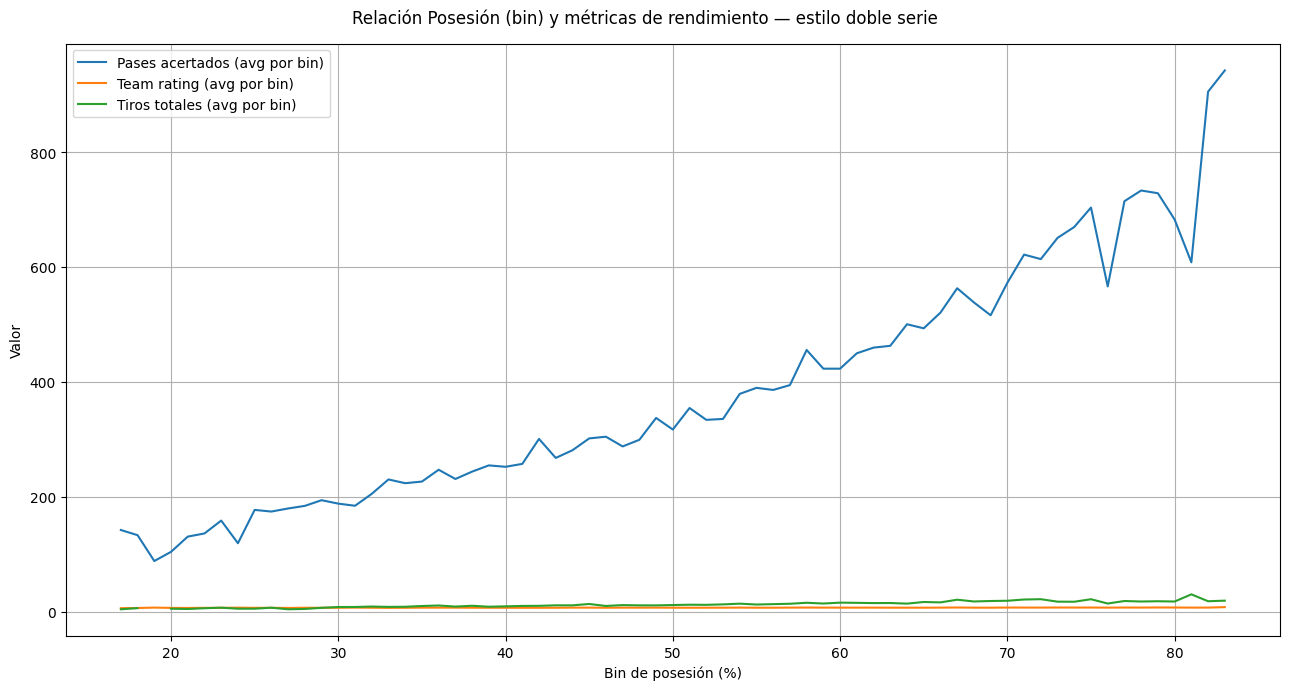

In [0]:
# ---- Gráfico al estilo que quieres ----
fig, ax1 = plt.subplots(num=None, figsize=(13, 7), facecolor='w', edgecolor='k')
ax1.plot(pdf["pos_bin"], pdf["avg_acc_pass"], label="Pases acertados (avg por bin)")

if "avg_team_rating" in pdf.columns and not pdf["avg_team_rating"].isna().all():
    ax1.plot(pdf["pos_bin"], pdf["avg_team_rating"], label="Team rating (avg por bin)")

if "avg_team_shots" in pdf.columns and not pdf["avg_team_shots"].isna().all():
    ax1.plot(pdf["pos_bin"], pdf["avg_team_shots"], label="Tiros totales (avg por bin)")

fig.suptitle("Relación Posesión (bin) y métricas de rendimiento — estilo doble serie")
ax1.legend()
plt.xlabel("Bin de posesión (%)")
plt.ylabel("Valor")
plt.grid(True)
plt.tight_layout()
plt.show()

In [0]:
import pandas as pd
from pyspark.sql import functions as F

def to_pandas(df, cols=None, limit=None):
    if hasattr(df, "select"):
        sdf = df.select(*cols) if cols else df
        if limit: sdf = sdf.limit(limit)
        return sdf.toPandas()
    return df[cols] if cols else df

# Suma de tiros por equipo-partido desde players_match
pm_shots = (to_pandas(df_players_match, ["match","team","total_scoring_att"])
            .assign(total_scoring_att=lambda d: pd.to_numeric(d["total_scoring_att"], errors="coerce"))
            .groupby(["match","team"], dropna=True)["total_scoring_att"].sum().reset_index()
            .rename(columns={"match":"match_id","team":"team_id","total_scoring_att":"pm_team_shots"}))

t_shots = (to_pandas(df_teams, ["match_id","team_id","total_scoring_att"])
           .assign(total_scoring_att=lambda d: pd.to_numeric(d["total_scoring_att"], errors="coerce"))
           .rename(columns={"total_scoring_att":"teams_team_shots"}))

cmp = (t_shots.merge(pm_shots, on=["match_id","team_id"], how="inner")
              .assign(diff=lambda d: d["teams_team_shots"] - d["pm_team_shots"]))
print("Comparación tiros — filas:", len(cmp))
print("Abs(diff) ≤ 1:", (cmp["diff"].abs() <= 1).mean()*100, "%")


Comparación tiros — filas: 760
Abs(diff) ≤ 1: 99.86842105263159 %


In [0]:
# Tabla equipo-partido con features clave
t = to_pandas(df_teams, ["match_id","team_id","team_name","team","date",
                         "possession_percentage","accurate_pass","total_scoring_att",
                         "team_rating","goals"]).copy()

for c in ["possession_percentage","accurate_pass","total_scoring_att","team_rating","goals"]:
    if c in t.columns: t[c] = pd.to_numeric(t[c], errors="coerce")

# Resultado del partido por equipo (si tienes 'goals' en teams ya indica GF)
# (Si además quisieras GA, puedes traerlo cruzando contra el rival en el mismo match_id)
t["pos_bin"] = t["possession_percentage"].round()


In [0]:
# Win/draw/loss aproximado si tienes 'goals'
if "goals" in t.columns:
    # GA = goles del rival por mismo partido y equipo contrario
    rival = t[["match_id","team_id","goals"]].rename(columns={"team_id":"rival_id","goals":"ga"})
    t = t.merge(rival, how="left", on="match_id")
    # ga correcto: el del rival, no el mismo team_id
    t.loc[t["team_id"]==t["rival_id"], "ga"] = pd.NA
    t["ga"] = t.groupby("match_id")["ga"].transform(lambda s: s.bfill().ffill())
    t["gd"] = t["goals"] - t["ga"]
    t["result"] = pd.NA
    t.loc[t["gd"]>0, "result"] = "W"
    t.loc[t["gd"]==0, "result"] = "D"
    t.loc[t["gd"]<0, "result"] = "L"


In [0]:
# Suma de tiros desde players_match para comparar/usar
pm = (to_pandas(df_players_match, ["match","team","total_scoring_att"])
      .rename(columns={"match":"match_id","team":"team_id"})
      .assign(total_scoring_att=lambda d: pd.to_numeric(d["total_scoring_att"], errors="coerce"))
      .groupby(["match_id","team_id"], dropna=True)["total_scoring_att"].sum().reset_index()
      .rename(columns={"total_scoring_att":"pm_team_shots"}))

X = t.merge(pm, on=["match_id","team_id"], how="left")

In [0]:
# ======== PREP: helpers para Spark/Pandas y casteos ========
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

def is_spark(df): 
    return hasattr(df, "select")

def to_pandas(df, cols=None):
    """Convierte Spark->pandas o devuelve copia de pandas."""
    if is_spark(df):
        sdf = df.select(*cols) if cols else df
        return sdf.toPandas()
    return df[cols].copy() if cols else df.copy()


In [0]:
# ======== 1) Tabla equipo-partido limpia + resultado correcto ========
t = to_pandas(
    df_teams, 
    ["match_id","team_id","team_name","team","date",
     "possession_percentage","accurate_pass","total_scoring_att","team_rating","goals"]
)

# Cast numéricos
for c in ["possession_percentage","accurate_pass","total_scoring_att","team_rating","goals","match_id","team_id"]:
    if c in t.columns:
        t[c] = pd.to_numeric(t[c], errors="coerce")

# GA del rival por self-join (2 equipos por match)
ga_df = (t[["match_id","team_id","goals"]]
         .merge(t[["match_id","team_id","goals"]], on="match_id", suffixes=("","_opp")))
ga_df = ga_df[ga_df["team_id"] != ga_df["team_id_opp"]][["match_id","team_id","goals_opp"]]
ga_df = ga_df.rename(columns={"goals_opp":"ga"})

t = t.merge(ga_df, on=["match_id","team_id"], how="left")
t["gd"] = t["goals"] - t["ga"]
t["result"] = np.select([t["gd"]>0, t["gd"]==0, t["gd"]<0], ["W","D","L"], default=pd.NA)

# Bins de posesión (ancho 5%) -> en FLOAT (no Int64)
BIN = 5
t["pos_bin"] = pd.to_numeric(t["possession_percentage"], errors="coerce")
t["pos_bin"] = (np.floor(t["pos_bin"]/BIN)*BIN).astype(float)

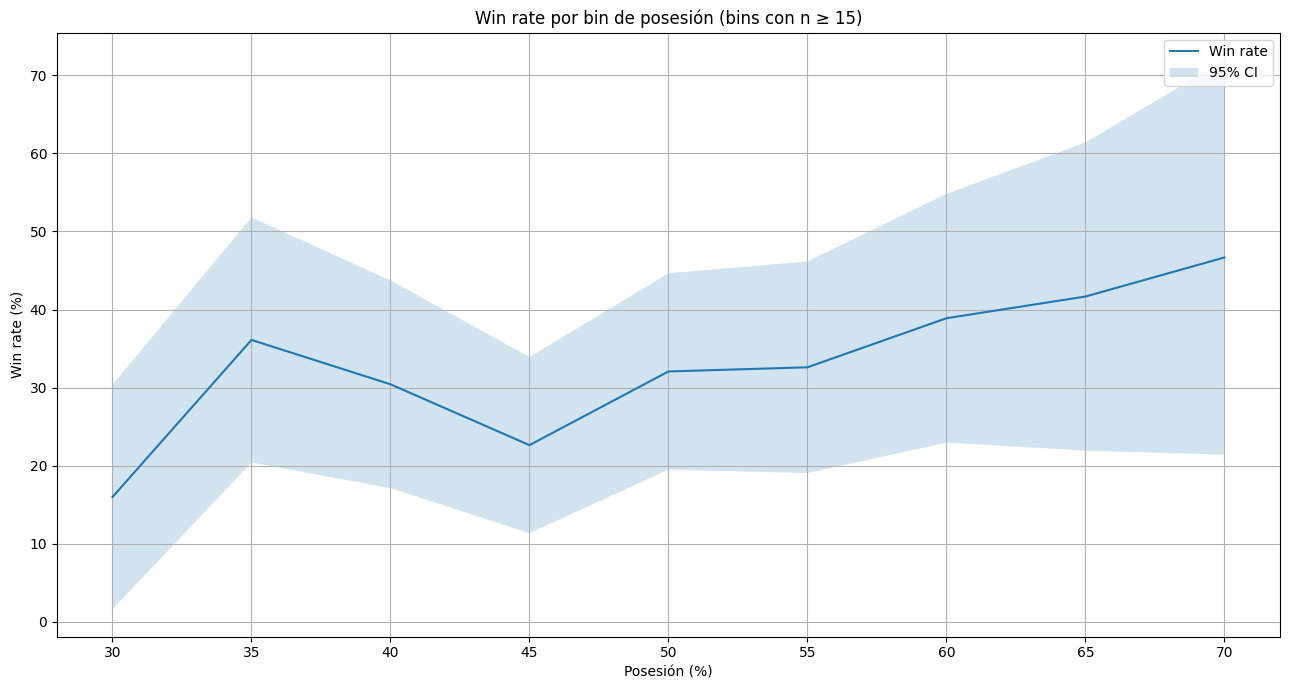

Partidos por bin (muestra):
 pos_bin  n
    30.0 25
    35.0 36
    40.0 46
    45.0 53
    50.0 53
    55.0 46
    60.0 36
    65.0 24
    70.0 15


In [0]:
# ======== 2) Win-rate por bin con bandas de confianza ========
MIN_N = 15  # mínimo de partidos por bin para evitar picos engañosos

g = t.dropna(subset=["pos_bin","result"]).groupby("pos_bin", dropna=True)
n = g.size()
wins = g["result"].apply(lambda s: (s=="W").sum())
p = (wins / n).fillna(0.0)

# Banda 95% (aprox normal) y coerción a float para plot
se = np.sqrt(p*(1-p)/n.clip(lower=1))
wr = (pd.DataFrame({"pos_bin": p.index, "n": n.values,
                    "win_rate": (p*100).values,
                    "lo": ((p-1.96*se)*100).values,
                    "hi": ((p+1.96*se)*100).values})
        .query("n >= @MIN_N")
        .sort_values("pos_bin"))

# ---- FIX tipos antes de graficar
for col in ["pos_bin","win_rate","lo","hi"]:
    wr[col] = pd.to_numeric(wr[col], errors="coerce").astype(float)
wr = wr.replace([np.inf,-np.inf], np.nan).dropna(subset=["pos_bin","win_rate","lo","hi"])

x  = wr["pos_bin"].to_numpy(dtype=float)
y  = wr["win_rate"].to_numpy(dtype=float)
lo = wr["lo"].to_numpy(dtype=float)
hi = wr["hi"].to_numpy(dtype=float)
m  = np.isfinite(x) & np.isfinite(y) & np.isfinite(lo) & np.isfinite(hi)

fig, ax = plt.subplots(figsize=(13,7), facecolor="w", edgecolor="k")
ax.plot(x[m], y[m], label="Win rate")
ax.fill_between(x[m], lo[m], hi[m], alpha=0.2, label="95% CI")
ax.set_title(f"Win rate por bin de posesión (bins con n ≥ {MIN_N})")
ax.set_xlabel("Posesión (%)"); ax.set_ylabel("Win rate (%)")
ax.grid(True); ax.legend(); plt.tight_layout(); plt.show()

print("Partidos por bin (muestra):")
print(wr[["pos_bin","n"]].tail(10).to_string(index=False))


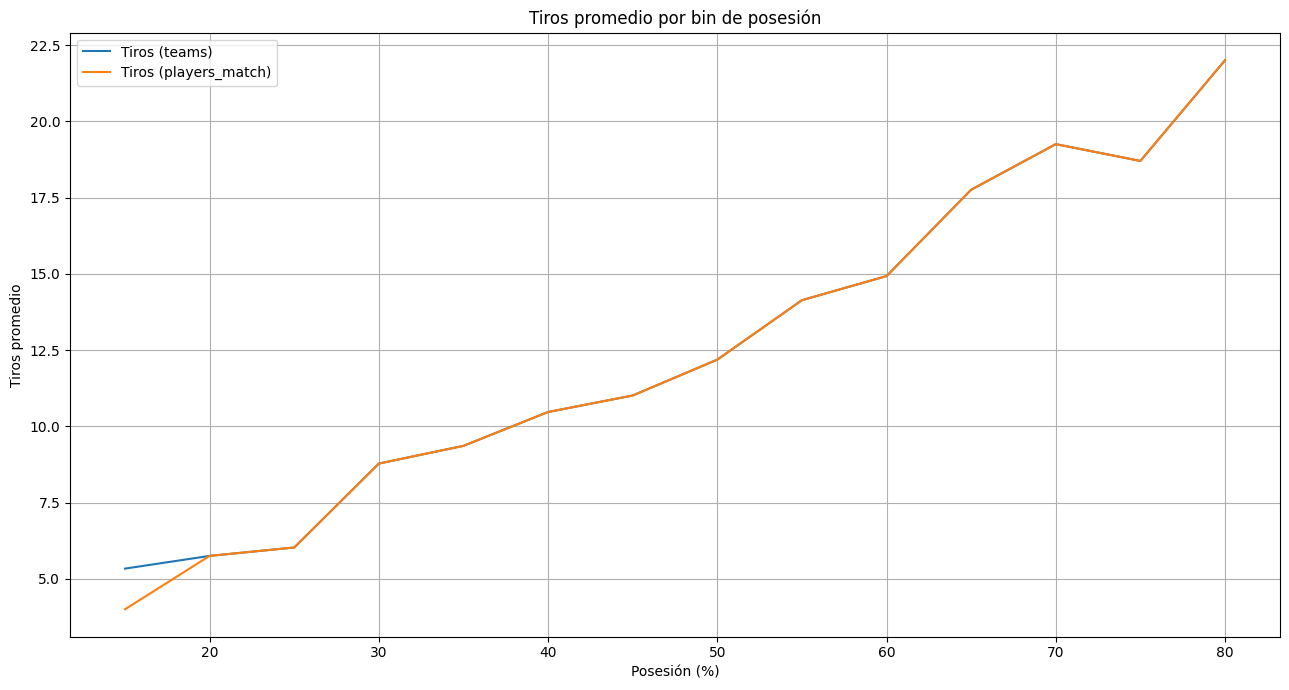

In [0]:
# ======== 3) Tiros promedio por bin (teams vs players_match) ========
pm = to_pandas(df_players_match, ["match","team","total_scoring_att"])
pm = pm.rename(columns={"match":"match_id","team":"team_id",
                        "total_scoring_att":"pm_shots"})
for c in ["match_id","team_id","pm_shots"]:
    pm[c] = pd.to_numeric(pm[c], errors="coerce")

pm_team = (pm.groupby(["match_id","team_id"], dropna=True)["pm_shots"]
             .sum().reset_index())

X = t.merge(pm_team, on=["match_id","team_id"], how="left")

shots = (X.groupby("pos_bin")[["total_scoring_att","pm_shots"]]
           .mean().reset_index()
           .sort_values("pos_bin"))

# ---- FIX tipos antes de graficar
for col in ["pos_bin","total_scoring_att","pm_shots"]:
    shots[col] = pd.to_numeric(shots[col], errors="coerce").astype(float)
shots = shots.replace([np.inf,-np.inf], np.nan).dropna(subset=["pos_bin","total_scoring_att","pm_shots"])

xs = shots["pos_bin"].to_numpy(dtype=float)
y1 = shots["total_scoring_att"].to_numpy(dtype=float)
y2 = shots["pm_shots"].to_numpy(dtype=float)
ms = np.isfinite(xs) & np.isfinite(y1) & np.isfinite(y2)

fig, ax = plt.subplots(figsize=(13,7), facecolor="w", edgecolor="k")
ax.plot(xs[ms], y1[ms], label="Tiros (teams)")
ax.plot(xs[ms], y2[ms], label="Tiros (players_match)")
ax.set_title("Tiros promedio por bin de posesión")
ax.set_xlabel("Posesión (%)"); ax.set_ylabel("Tiros promedio")
ax.grid(True); ax.legend(); plt.tight_layout(); plt.show()


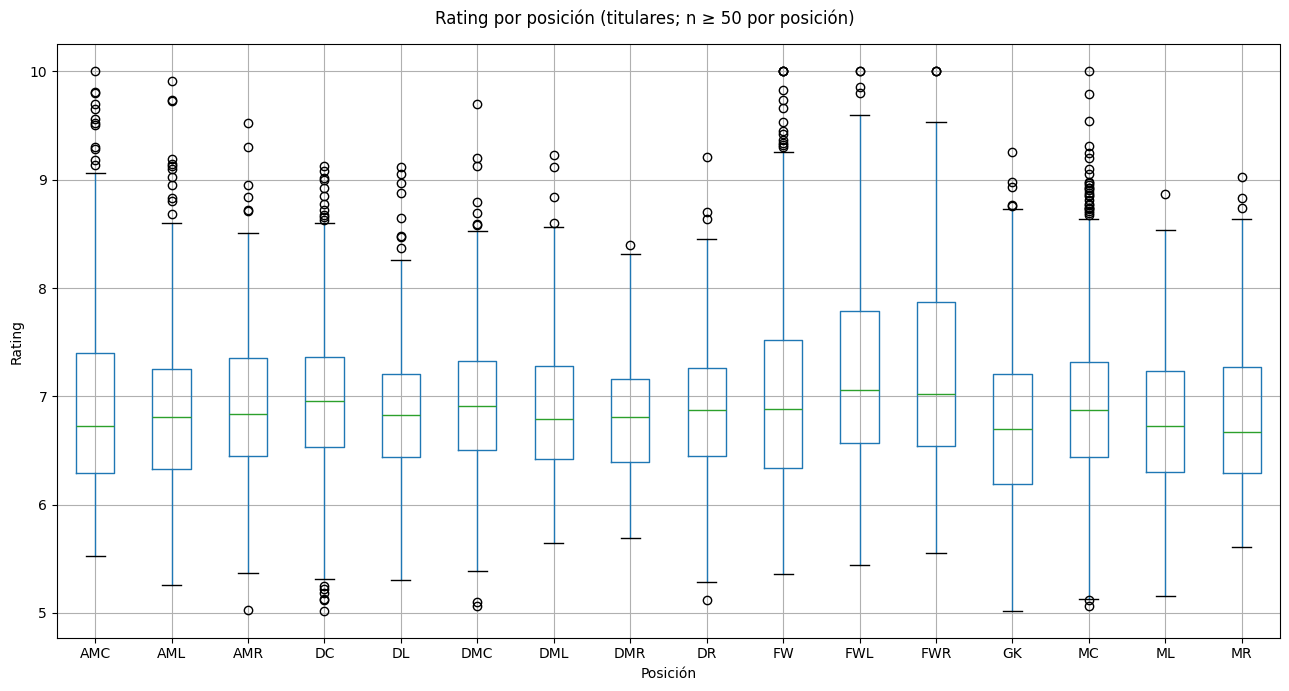

In [0]:
# ======== 4) Boxplot de rating por posición (limpio) ========
pm2 = to_pandas(df_players_match, ["player_position_info","player_rating","formation_place"])
pm2["player_rating"]   = pd.to_numeric(pm2["player_rating"], errors="coerce")
pm2["formation_place"] = pd.to_numeric(pm2["formation_place"], errors="coerce")

# Filtro: titulares (<=11), rating válido [5, 10]
pm2 = pm2[
    (pm2["formation_place"].between(1, 11)) &
    (pm2["player_rating"].between(5.0, 10.0))
].dropna(subset=["player_position_info","player_rating"])

MIN_POS = 50
keep = pm2["player_position_info"].value_counts().pipe(lambda s: s[s>=MIN_POS]).index
bp = pm2[pm2["player_position_info"].isin(keep)]

fig, ax = plt.subplots(figsize=(13,7), facecolor="w", edgecolor="k")
bp.boxplot(by="player_position_info", column="player_rating", grid=True, ax=ax)
ax.set_title("")  # quita subtítulo extra
fig.suptitle(f"Rating por posición (titulares; n ≥ {MIN_POS} por posición)")
ax.set_xlabel("Posición"); ax.set_ylabel("Rating")
plt.tight_layout(); plt.show()

In [0]:
import pandas as pd
import json
import os
from pyspark.sql import Row
from pyspark.sql import functions as F

# Ruta base del Volume donde subiste los archivos
catalog = "workspace"
schema  = "default"
volume  = "parcial"
BASE = f"/Volumes/{catalog}/{schema}/{volume}"
CSVS = f"{BASE}/csv_out"
CSV1 = f"{BASE}/csv_out/JugadoresJSON.csv"
CSV2 = f"{BASE}/csv_out/TeamsJSON.csv"

# Cambia estas rutas según lo que copiaste desde Databricks FileStore
jugadores_json_df = pd.read_csv(CSV1)
teams_json_df = pd.read_csv(CSV2)


Ranking Mejores Jugadores

In [0]:
top_players = jugadores_json_df.groupby('player_name')['player_rating'].mean().sort_values(ascending=False).head(10)
print(top_players)

player_name
Mohamed Salah        7.691111
Kevin De Bruyne      7.597895
Harry Kane           7.596216
Philippe Coutinho    7.495333
Paul Pogba           7.478889
Eden Hazard          7.469714
Fernandinho          7.436471
Christian Eriksen    7.399730
Wilfried Zaha        7.381379
David Silva          7.326333
Name: player_rating, dtype: float64


In [0]:
features = ['player_rating', 'goals', 'total_scoring_att', 'touches', 'goal_assist']
corr_matrix = jugadores_json_df[features].corr()
print(corr_matrix['player_rating'].sort_values(ascending=False))


player_rating        1.000000
goals                0.487139
touches              0.450278
goal_assist          0.365044
total_scoring_att    0.346062
Name: player_rating, dtype: float64


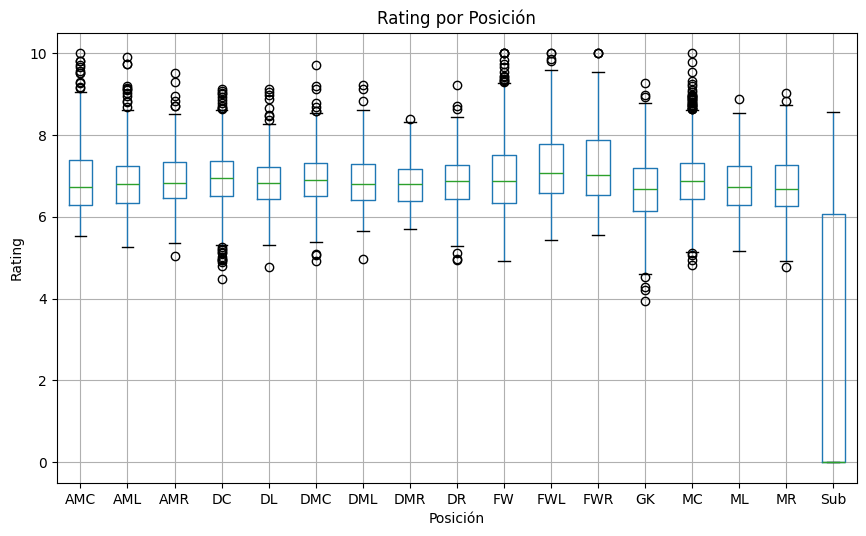

In [0]:
import matplotlib.pyplot as plt

jugadores_json_df.boxplot(column='player_rating', by='player_position_info', figsize=(10,6))
plt.title('Rating por Posición')
plt.suptitle('')
plt.xlabel('Posición')
plt.ylabel('Rating')
plt.show()

<Axes: xlabel='possession_percentage', ylabel='team_rating'>

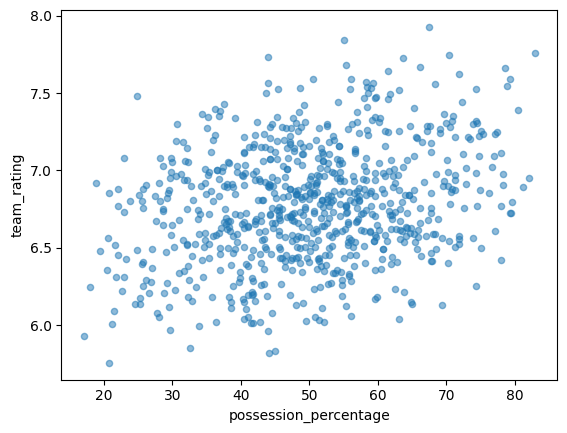

In [0]:
teams_json_df[['possession_percentage', 'team_rating']].dropna().plot.scatter(x='possession_percentage', y='team_rating', alpha=0.5)

Ranking de Equipos

In [0]:
ofensivos = teams_json_df.groupby('team_name')[['possession_percentage', 'won_corners', 'total_scoring_att']].mean()
ofensivos.sort_values(by='total_scoring_att', ascending=False).head(10)

,possession_percentage,won_corners,total_scoring_att
team_name,,,
Manchester City,71.750000,7.500000,17.500000
Liverpool,60.760526,6.078947,16.789474
Tottenham,62.128947,6.500000,16.394737
Chelsea,55.684211,6.270270,15.947368
Arsenal,61.847368,6.081081,15.631579
Manchester United,54.755263,5.789474,13.473684
Crystal Palace,45.094737,5.526316,12.526316
Bournemouth,48.115789,5.736842,12.210526
Newcastle United,41.610526,4.638889,11.868421


<Axes: xlabel='team', ylabel='team_rating'>

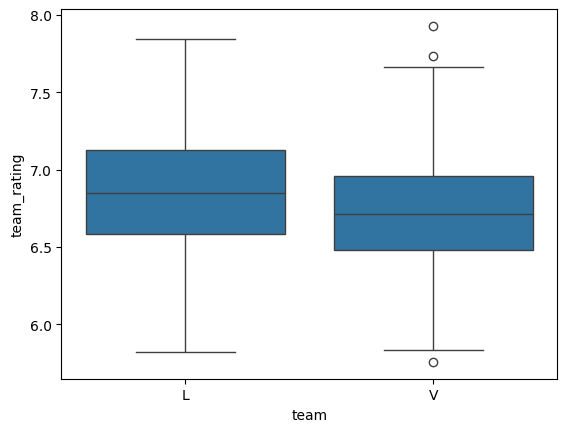

In [0]:
import seaborn as sns

sns.boxplot(x='team', y='team_rating', data=teams_json_df)

<Axes: xlabel='possession_percentage', ylabel='player_rating'>

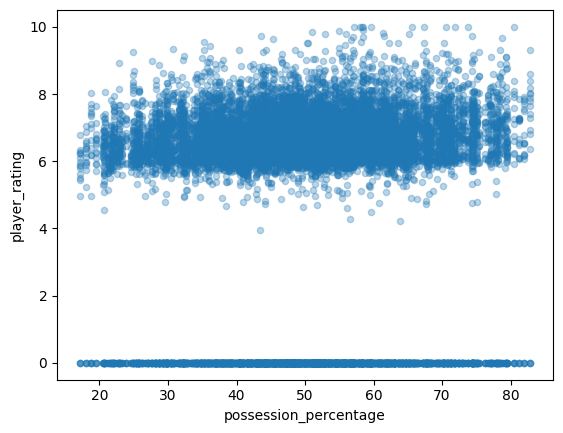

In [0]:
merged_df = jugadores_json_df.merge(teams_json_df[['match_id', 'team_id', 'possession_percentage']],
                                     left_on=['match', 'team'],
                                     right_on=['match_id', 'team_id'],
                                     how='left')
merged_df[['player_rating', 'possession_percentage']].dropna().plot.scatter(x='possession_percentage', y='player_rating', alpha=0.3)

In [0]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# Usamos columnas válidas
features = ['goals', 'total_scoring_att', 'touches', 'goal_assist']
df_model = jugadores_json_df[features + ['player_rating']].dropna()

# Variables
X = df_model[features]
y = df_model['player_rating']

# Entrenamiento y evaluación
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression().fit(X_train, y_train)

y_pred = model.predict(X_test)
print("R² Score:", r2_score(y_test, y_pred))


R² Score: 0.33121520011032923
